In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [4]:

!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu


In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

C:\Users\pkper\AppData\Local\Temp\ipykernel_11696\3067738315.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [23]:
df= pd.read_csv('new_train - train.csv')
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159604,NaN,mai**,1,1,0,0,1,0
159605,NaN,b**d,1,1,0,0,1,0
159606,NaN,p**da,1,1,0,0,1,0
159607,NaN,omb****,1,1,0,0,1,0


In [24]:
from tensorflow.keras.layers import TextVectorization

In [25]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [26]:

MAX_FEATURES = 200000 

In [27]:

vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [28]:

vectorizer.adapt(X.values)

In [9]:

vectorized_text = vectorizer(X.values)

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [11]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [13]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [14]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [17]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [16]:

history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
   9/6981 [..............................] - ETA: 2:01:15 - loss: 0.6760

KeyboardInterrupt: 

In [30]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

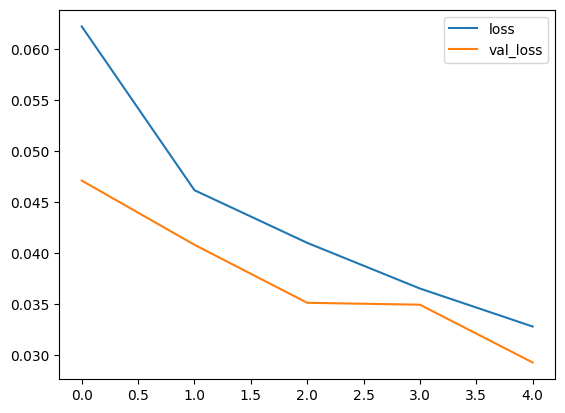

In [31]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [49]:
input_text = vectorizer('punda')

In [50]:
res = model.predict(np.expand_dims(input_text,0))
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


array([[1.5517775e-02, 2.8173378e-07, 6.1580632e-04, 5.1034160e-04,
        1.2325705e-03, 7.4212418e-05]], dtype=float32)

In [3]:
model.save('toxicity.h5')

NameError: name 'model' is not defined

In [42]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [44]:
!pip install gradio

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 59.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 80.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 6.6 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=5584 sha256=07b5cb8cf61c7b4cddc9f9cdc33812f275202ba3a15c1fb263b39272e41034cd
  Stored in directory: /root/.cache/pip/wheels/bd/65/9a/671fc6dcde07d4418df0c592f8df512b26d7a0029c2a23dd81
Successfully built ffmpy
  Attempting uninstall: websockets
    Found existing installation: websockets 12.0
    Uninstalling websockets-12.0:
      Successfully uninstalled websockets-12.0
  Attempting uninst

In [46]:
import tensorflow as tf
import gradio as gr
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

AttributeError: module 'gradio' has no attribute 'inputs'

In [18]:
import tensorflow as tf
model = tf.keras.models.load_model('python-model/toxicity_colab.h5')

In [53]:
res = model.predict(vectorizer(['koothi mairu']))
res

1/1 [==============================] - 0s 82ms/step


array([[0.9483428 , 0.33786726, 0.76717776, 0.13121015, 0.7274364 ,
        0.24751167]], dtype=float32)

In [40]:
df.tail(30)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159579,NaN,ungagoya,1,1,0,0,1,0
159580,NaN,thayoli,1,1,0,0,1,0
159581,NaN,unn pundaiya naku,1,1,0,0,1,0
159582,NaN,otha mairu mari pesura,1,1,0,0,1,0
159583,NaN,nee enna periya pudinginu nenapa,1,1,0,0,1,0
159584,NaN,otha nee enna avlo periya ala,1,1,0,0,1,0
159585,NaN,baadu,1,1,0,0,1,0
159586,NaN,chunnni,1,1,0,0,1,0
159587,NaN,ennoda pola ombudaa,1,1,0,0,1,0
159588,NaN,ommbu,1,1,0,0,1,0


In [52]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.1.0
asttokens                    2.2.1
astunparse                   1.6.3
attrs                        23.2.0
backcall                     0.2.0
cachetools                   5.3.2
certifi                      2023.11.17
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.1.2
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.6.6
decorator                    5.1.1
distlib                      0.3.8
entrypoints                  0.4
exceptiongroup               1.0.4
executing                    1.2.0
fastjsonschema               2.19.1
filelock                     3.13.1
flatbuffers                  23.5.26
fonttools                    4.47.2
gast                         0.5.4
google-auth                  2.26.2
google-auth-oauthlib         1.2.0
google-pasta                 0.2.0
